In [16]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from IPython.core.display import Image as IPImage

# is GPU available?
gpu = torch.cuda.is_available()

# defining device where to to the computation
device = torch.device(0) if gpu else torch.device("cpu")
device

device(type='cuda', index=0)

In [17]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../Dataset/Compiled/Classification/'
nclasses   = 9

# Set the desired image size for rescaling and maximum value for normalization

width       = 224 
height      = 224
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Create training, validation, and test sets.

trainset = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Train"+"/*.jpg")
validset = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Valid"+"/*.jpg")
testset  = glob("H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test"+"/*.jpg")

# Set output model name

model_name  = 'FishCNN.pth'

In [18]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.

prep = transforms.Compose([
    transforms.Resize((width, height), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias='True'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation,
# and test sets. We will do that during training, then by adding affine transformations and increasing the number
# of epochs, we are actually implementing data augmentation.

aug = transforms.Compose([
    transforms.Resize((300, 300), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias='True'),
    transforms.RandomAffine(
        degrees=10, interpolation=transforms.InterpolationMode.BILINEAR, fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((width, height), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias='True'),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create an image dataset by applying one of the preprocessing transformations above


class ImageDataset():  # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset
        self.targets = [int(str(x).split("\\")[-1].split("_")[0])
                        for x in self.dataset]
        self.transform = transform

    def __len__(self): return len(self.dataset)

    def __getitem__(self, ix):  # returns the item at position ix
        filename = self.dataset[ix]
        target = self.targets[ix]
        image = Image.open(filename)  # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else:  # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float()
        return (image, target)

    def get_path(self, ix):
        return self.dataset[ix]

In [19]:
trainset = ImageDataset(trainset, prep) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

Number of images: 5160

Images are 224x224x3

Class of the image:  1

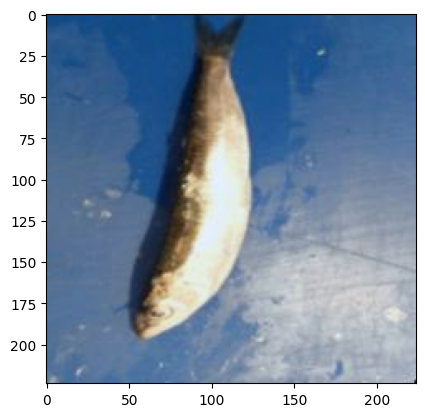

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[10] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

In [20]:
batchsize = 100
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

══════════════════════════════════════════════════════════════════

list of 2 items

Tensor  Shape: torch.Size([100, 3, 224, 224])   Min: -2.118     Max: 2.640      Mean: -0.189    dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([100])        Min: 0.000      Max: 8.000      Mean: 3.510     dtype: torch.int64 
@ cpu

══════════════════════════════════════════════════════════════════

In [21]:
def Criterion(model, preds, targets):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    # compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1]  # same as argmax
    acc = torch.sum(pred_labels == targets.data)
    n = pred_labels.size(0)
    acc = acc/n
    return loss, acc


# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        # defining convolutional layer
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1),
        # defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        # defining activation layer
        nn.ReLU(),
        # defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )


class FishNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(FishNet, self).__init__()

        # defining feature extractor
        self.features = nn.Sequential(
            conv_block(input_shape[0], 32, 2),
            conv_block(32, 64, 2),
            conv_block(64, 128, 2),
            conv_block(128, 256, 2)
        )

        # defining classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=50176, out_features=128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(256, 64, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(64, num_classes)
        )

        # initialize weights
        self._initialize_weights()

    def forward(self, x):
       # extracts features
        x = self.features(x)

        # classifies features
        y = self.classifier(x)

        return y

    def _initialize_weights(self):
        # for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()

In [8]:
model = FishNet([3, width, height], nclasses).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)
criterion = Criterion
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [9]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

In [10]:
# initializing variables
n_epochs = 100
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%20==0: log.report_avgs(ex+1)
    lr_scheduler.step()

EPOCH: 20.000  trn_acc: 0.966  val_acc: 0.782  val_loss: 1.132  trn_loss: 0.121  (334.62s - 1338.49s remaining)
EPOCH: 40.000  trn_acc: 0.996  val_acc: 0.742  val_loss: 2.204  trn_loss: 0.012  (652.95s - 979.43s remaining)
EPOCH: 60.000  trn_acc: 0.997  val_acc: 0.744  val_loss: 1.996  trn_loss: 0.009  (969.04s - 646.02s remaining)
EPOCH: 80.000  trn_acc: 0.999  val_acc: 0.796  val_loss: 1.401  trn_loss: 0.006  (1287.84s - 321.96s remaining)
EPOCH: 100.000  trn_acc: 0.998  val_acc: 0.767  val_loss: 2.163  trn_loss: 0.007  (1602.48s - 0.00s remaining)


100%|██████████| 201/201 [00:00<00:00, 2068.25it/s]


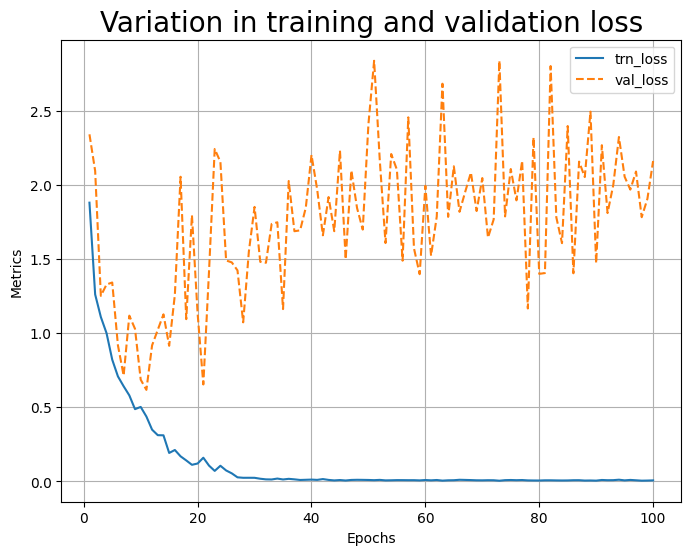

100%|██████████| 201/201 [00:00<00:00, 1969.08it/s]


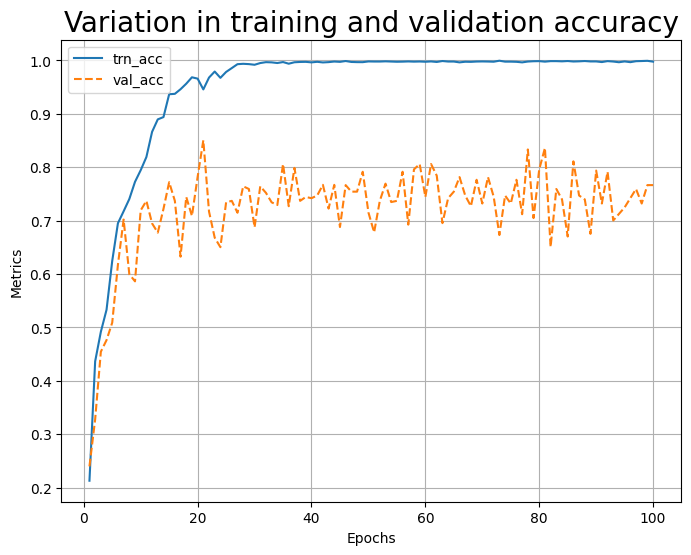

In [11]:
log.plot_epochs(['trn_loss','val_loss'], title='Variation in training and validation loss')
log.plot_epochs(['trn_acc','val_acc'], title='Variation in training and validation accuracy')

In [22]:
model = FishNet([3, width, height], nclasses)
model.load_state_dict(torch.load(model_name))
model.to(device)

FishNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, ker

In [25]:
def get_activations(model, x, device):
    # move input tensor x to the selected device
    x = x.to(device)
    # get activations after feature extraction
    x = model.features[0](x)
    x = model.features[1](x)
    x = model.features[2](x)
    x = model.features[3](x)
    return torch.nn.functional.interpolate(x, scale_factor=(16, 16), mode='bicubic',
                                           recompute_scale_factor=True)


def get_output_of_the_model(model, x, device):
    # put the model in the evaluation mode
    model.eval()
    # move input tensor x to the selected device
    x = x.to(device)
    # execute the model with gradients
    output = model(x)
    return (output)


def get_heatmap(model, x, device, model_name, labels_map):
    # add one dimension (dim=0 must be the number of images)
    xin = x.unsqueeze(0)

    # get the output of the feature extractor
    activ = get_activations(model, xin, device)

    # get the predictions at the output of the decision layer
    logits = get_output_of_the_model(model, xin, device)

    # get the most confident prediction
    pred = logits.max(-1)[-1]
    print("predicted label: ", labels_map[pred.cpu().detach().numpy()[0]])

    # compute gradients with respect to the most confident prediction
    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)

    print(activ.shape)
    # only conv2D generates gradients in the feature extractor: extracts them.
    for layer_name, layer in model.features[-1].named_children():
        if layer_name == '0':
            print(layer)
            print(layer.weight)
            print(layer.weight.grad)
            grad1 = layer.weight.grad
            nchannels1 = grad1.shape[0]
            # compute the weighted mean of the activations across channels using the mean value of the gradient
            # of each filter parameter as weight.
            for i in range(16):
                activ[:, i, :, :] *= grad1[i].mean()

    heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

    # convert to numpy, normalize, and resize to the input size
    heatmap = heatmap.squeeze(0).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
    return (heatmap)


def display_image_with_heatmap(img, heatmap, scale):
    heatmap = np.uint8(255.0*heatmap)
    width = int(heatmap.shape[1]*scale)
    height = int(heatmap.shape[0]*scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap*0.7 + img*0.3)
    plt.imshow(heatmap)
    plt.show()

true label:  Gilt Head Bream

Photo path:  H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test\001_00006.jpg

predicted label:  Red Sea Bream

torch.Size([1, 256, 224, 224])

Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

Parameter containing:
Parameter[256, 128, 3, 3] n=294912 x∈[-0.194, 0.241] μ=0.002 σ=0.035 grad cuda:0

tensor[256, 128, 3, 3] n=294912 x∈[-0.344, 0.531] μ=-0.001 σ=0.056 cuda:0

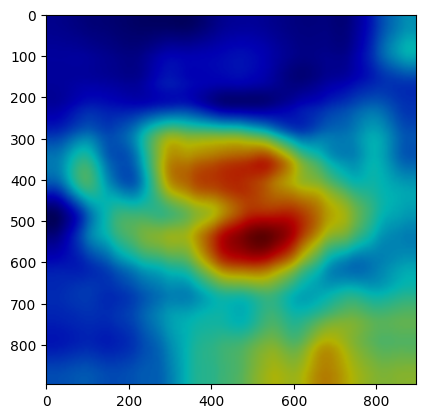

In [26]:
# get the first image tensor
labels_map = {
    0: "Black Sea Sprat",
    1: "Gilt Head Bream",
    2: "Hourse Mackerel",
    3: "Red Mullet",
    4: "Red Sea Bream",
    5: "Sea Bass",
    6: "Shrimp",
    7: "Striped Red Mullet",
    8: "Trout",
}

x = testset[17][0]
true_label = testset[17][1]
print("true label: ", labels_map[true_label])
print("Photo path: ", testset.get_path(17))
heatmap = get_heatmap(model, x, device, model_name, labels_map)
x = x.permute(1, 2, 0).numpy()
if x.shape[2] == 1:  # convert it to three channels
    x = x.squeeze(2)
    x = np.stack((x,) * 3, axis=-1)
display_image_with_heatmap(x, heatmap, 4)

true label:  Gilt Head Bream

Photo path:  H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test\001_00027.jpg

predicted label:  Gilt Head Bream

torch.Size([1, 256, 224, 224])

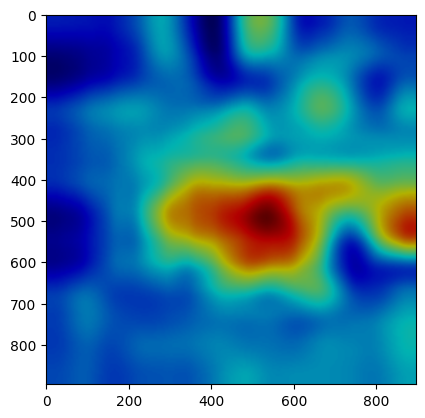

In [11]:
x = testset[20][0]
true_label = testset[20][1]
print("true label: ", labels_map[true_label])
print("Photo path: ", testset.get_path(20))
heatmap = get_heatmap(model, x, device, model_name, labels_map)
x = x.permute(1, 2, 0).numpy()
if x.shape[2] == 1:  # convert it to three channels
    x = x.squeeze(2)
    x = np.stack((x,) * 3, axis=-1)
display_image_with_heatmap(x, heatmap, 4)

true label:  Gilt Head Bream

Photo path:  H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test\001_00033.jpg

predicted label:  Red Sea Bream

torch.Size([1, 256, 224, 224])

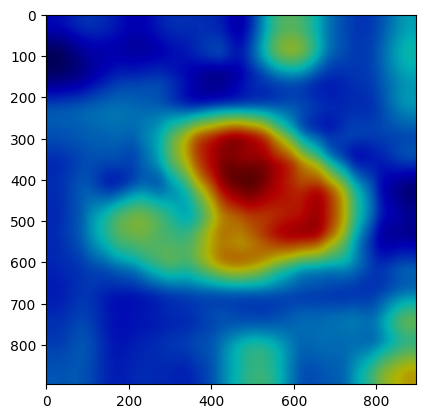

In [12]:
x = testset[23][0]
true_label = testset[23][1]
print("true label: ", labels_map[true_label])
print("Photo path: ", testset.get_path(23))
heatmap = get_heatmap(model, x, device, model_name, labels_map)
x = x.permute(1, 2, 0).numpy()
if x.shape[2] == 1:  # convert it to three channels
    x = x.squeeze(2)
    x = np.stack((x,) * 3, axis=-1)
display_image_with_heatmap(x, heatmap, 4)

true label:  Gilt Head Bream

Photo path:  H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test\001_00048.jpg

predicted label:  Red Sea Bream

torch.Size([1, 256, 224, 224])

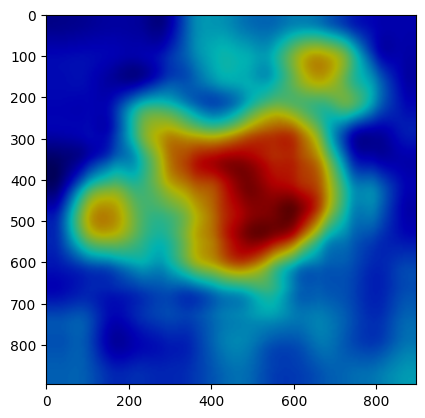

In [13]:
x = testset[27][0]
true_label = testset[27][1]
print("true label: ", labels_map[true_label])
print("Photo path: ", testset.get_path(27))
heatmap = get_heatmap(model, x, device, model_name, labels_map)
x = x.permute(1, 2, 0).numpy()
if x.shape[2] == 1:  # convert it to three channels
    x = x.squeeze(2)
    x = np.stack((x,) * 3, axis=-1)
display_image_with_heatmap(x, heatmap, 4)

true label:  Black Sea Sprat

Photo path:  H:/Github/Deep-Learning-Unicamp/Trabalho/Dataset/Compiled/Classification/Test\000_00039.jpg

predicted label:  Black Sea Sprat

torch.Size([1, 256, 224, 224])

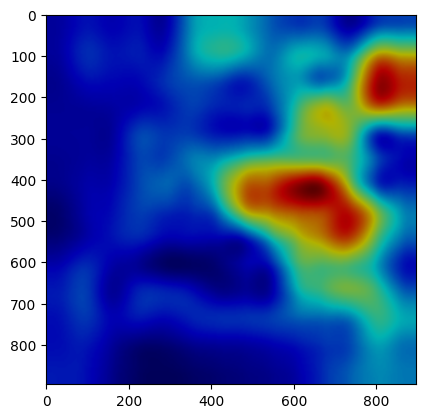

In [14]:
x = testset[11][0]
true_label = testset[11][1]
print("true label: ", labels_map[true_label])
print("Photo path: ", testset.get_path(11))
heatmap = get_heatmap(model, x, device, model_name, labels_map)
x = x.permute(1, 2, 0).numpy()
if x.shape[2] == 1:  # convert it to three channels
    x = x.squeeze(2)
    x = np.stack((x,) * 3, axis=-1)
display_image_with_heatmap(x, heatmap, 4)

In [17]:
torch.save(model.to('cpu').state_dict(), model_name)

Cohen Kappa score:  0.7993507810914993

Accuracy score:  0.8217054263565892

Confusion matrix: 
 [[14  0  0  0  1  0  0  0  1]
 [ 0  4  0  0  8  0  0  0  0]
 [ 1  2 13  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  1  0  0  2 12  0  0  0]
 [ 0  0  0  0  0  0 13  1  0]
 [ 0  0  0  0  0  0  1 14  0]
 [ 0  1  0  0  4  0  0  0  7]]

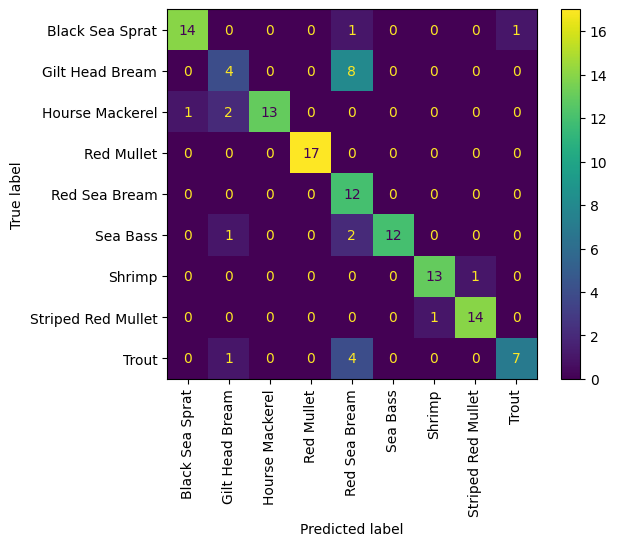

In [15]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model.eval()
model.to(device)
y_pred = []
y_true = []
for data in testload:
    ims, targets = data
    preds = model(ims.to(device))
    y_pred.extend(preds.argmax(dim=-1).cpu().numpy())
    y_true.extend(targets.cpu().numpy())


c_matrix = confusion_matrix(y_true, y_pred)
print("Cohen Kappa score: ", cohen_kappa_score(y_true, y_pred))
print("Accuracy score: ", accuracy_score(y_true, y_pred))
print("Confusion matrix: \n", c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=[labels_map[i] for i in range(9)])
disp.plot(xticks_rotation = 'vertical')
